# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

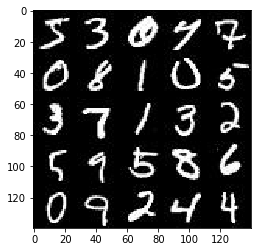

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

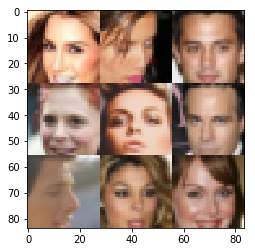

In [3]:
show_n_images = 10

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, stddev=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # in 28 28
        
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x1 = tf.maximum(alpha * x1, x1)
        # out 14 14 64
        
        x2 = tf.layers.conv2d(x1, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # out 7 7 126
        
        x3 = tf.layers.conv2d(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # out 4 4 126
        
        x4 = tf.layers.conv2d(x3, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha * x4, x4)
        # out 2 2 256
        
        flat = tf.reshape(x4, (-1, 2 * 2 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [12]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, stddev=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7 * 7 * 256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # Out 7 7 256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5 , strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # Out 14 14 128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5 , strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # Out 14 14 64
        
        x4 = tf.layers.conv2d_transpose(x3, 32, 5 , strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # Out 28 28 32
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        # Out 28 28 ocd
        
        return tf.tanh(logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [13]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_dummy, d_logits_dummy = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_dummy = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_dummy, labels=tf.zeros_like(d_model_dummy)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_dummy, labels=tf.ones_like(d_model_dummy)))

    d_loss = d_loss_real + d_loss_dummy

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    # d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
        
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    # with tf.control_dependencies(d_update_ops): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_ops, g_ops = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2 
                                
                _ = sess.run(d_ops, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_ops, feed_dict={input_z: batch_z, learn_rate: learning_rate})
                
                if steps % 10 == 0:
                    d_loss_train = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_loss_train = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(d_loss_train),
                         "Generator Loss: {:.4f}".format(g_loss_train))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8862... Generator Loss: 2.5631
Epoch 1/2... Discriminator Loss: 1.0876... Generator Loss: 1.1039
Epoch 1/2... Discriminator Loss: 1.0917... Generator Loss: 0.7552
Epoch 1/2... Discriminator Loss: 1.7235... Generator Loss: 0.3071
Epoch 1/2... Discriminator Loss: 1.0707... Generator Loss: 0.8027
Epoch 1/2... Discriminator Loss: 2.8648... Generator Loss: 0.0715
Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 1.0125
Epoch 1/2... Discriminator Loss: 1.4447... Generator Loss: 0.7561
Epoch 1/2... Discriminator Loss: 1.3587... Generator Loss: 0.8152
Epoch 1/2... Discriminator Loss: 1.2999... Generator Loss: 0.8524


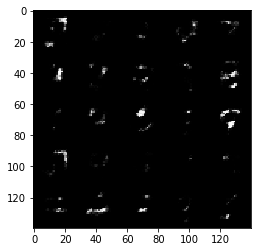

Epoch 1/2... Discriminator Loss: 1.1477... Generator Loss: 0.8492
Epoch 1/2... Discriminator Loss: 1.2132... Generator Loss: 0.8461
Epoch 1/2... Discriminator Loss: 1.2325... Generator Loss: 1.1849
Epoch 1/2... Discriminator Loss: 1.4860... Generator Loss: 0.3870
Epoch 1/2... Discriminator Loss: 1.1766... Generator Loss: 0.8499
Epoch 1/2... Discriminator Loss: 1.3502... Generator Loss: 1.1146
Epoch 1/2... Discriminator Loss: 1.5704... Generator Loss: 0.3583
Epoch 1/2... Discriminator Loss: 1.1544... Generator Loss: 0.6947
Epoch 1/2... Discriminator Loss: 1.0753... Generator Loss: 0.7771
Epoch 1/2... Discriminator Loss: 1.1912... Generator Loss: 0.6060


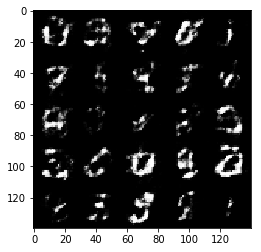

Epoch 1/2... Discriminator Loss: 1.1675... Generator Loss: 1.3145
Epoch 1/2... Discriminator Loss: 1.2050... Generator Loss: 0.5435
Epoch 1/2... Discriminator Loss: 1.2509... Generator Loss: 0.5449
Epoch 1/2... Discriminator Loss: 1.1319... Generator Loss: 0.7553
Epoch 1/2... Discriminator Loss: 0.9319... Generator Loss: 0.9221
Epoch 1/2... Discriminator Loss: 0.9174... Generator Loss: 1.4696
Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 0.5326
Epoch 1/2... Discriminator Loss: 1.2257... Generator Loss: 0.6984
Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 1.0281
Epoch 1/2... Discriminator Loss: 1.3486... Generator Loss: 0.3996


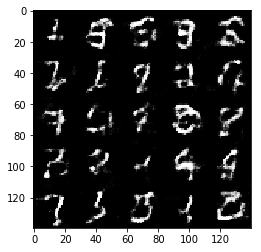

Epoch 1/2... Discriminator Loss: 1.7323... Generator Loss: 0.2493
Epoch 1/2... Discriminator Loss: 1.1719... Generator Loss: 0.6813
Epoch 1/2... Discriminator Loss: 1.3491... Generator Loss: 1.1558
Epoch 1/2... Discriminator Loss: 1.3243... Generator Loss: 0.6677
Epoch 1/2... Discriminator Loss: 1.2017... Generator Loss: 0.6966
Epoch 1/2... Discriminator Loss: 1.4285... Generator Loss: 0.4005
Epoch 1/2... Discriminator Loss: 0.9922... Generator Loss: 1.1924
Epoch 1/2... Discriminator Loss: 1.1822... Generator Loss: 0.5511
Epoch 1/2... Discriminator Loss: 1.4302... Generator Loss: 0.4508
Epoch 1/2... Discriminator Loss: 1.1304... Generator Loss: 0.5897


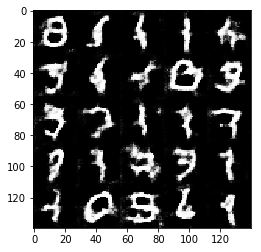

Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 1.5299
Epoch 1/2... Discriminator Loss: 1.0179... Generator Loss: 0.6134
Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 1.2612
Epoch 1/2... Discriminator Loss: 1.1469... Generator Loss: 0.5843
Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 0.5013
Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 1.0072
Epoch 2/2... Discriminator Loss: 1.2269... Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 1.2859... Generator Loss: 0.5163
Epoch 2/2... Discriminator Loss: 1.1875... Generator Loss: 0.7872
Epoch 2/2... Discriminator Loss: 1.6302... Generator Loss: 0.2989


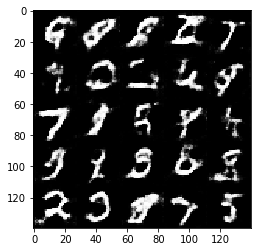

Epoch 2/2... Discriminator Loss: 1.1967... Generator Loss: 0.5575
Epoch 2/2... Discriminator Loss: 1.5644... Generator Loss: 0.3407
Epoch 2/2... Discriminator Loss: 1.3087... Generator Loss: 0.7814
Epoch 2/2... Discriminator Loss: 1.1006... Generator Loss: 0.9021
Epoch 2/2... Discriminator Loss: 1.0567... Generator Loss: 1.4597
Epoch 2/2... Discriminator Loss: 1.2109... Generator Loss: 1.6477
Epoch 2/2... Discriminator Loss: 1.5286... Generator Loss: 0.3297
Epoch 2/2... Discriminator Loss: 1.0497... Generator Loss: 1.1346
Epoch 2/2... Discriminator Loss: 1.4691... Generator Loss: 0.3852
Epoch 2/2... Discriminator Loss: 1.8550... Generator Loss: 0.2330


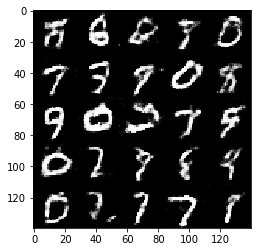

Epoch 2/2... Discriminator Loss: 1.0469... Generator Loss: 1.0314
Epoch 2/2... Discriminator Loss: 1.2225... Generator Loss: 0.6376
Epoch 2/2... Discriminator Loss: 1.1467... Generator Loss: 0.7436
Epoch 2/2... Discriminator Loss: 1.3427... Generator Loss: 0.5161
Epoch 2/2... Discriminator Loss: 1.2265... Generator Loss: 0.6048
Epoch 2/2... Discriminator Loss: 1.4290... Generator Loss: 0.4245
Epoch 2/2... Discriminator Loss: 1.1137... Generator Loss: 0.7239
Epoch 2/2... Discriminator Loss: 1.5343... Generator Loss: 0.3513
Epoch 2/2... Discriminator Loss: 0.8634... Generator Loss: 0.9372
Epoch 2/2... Discriminator Loss: 1.2282... Generator Loss: 0.5645


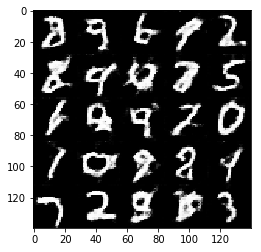

Epoch 2/2... Discriminator Loss: 1.2957... Generator Loss: 0.5468
Epoch 2/2... Discriminator Loss: 1.3162... Generator Loss: 0.4440
Epoch 2/2... Discriminator Loss: 1.2995... Generator Loss: 0.4895
Epoch 2/2... Discriminator Loss: 1.5977... Generator Loss: 0.3105
Epoch 2/2... Discriminator Loss: 1.8256... Generator Loss: 0.2789
Epoch 2/2... Discriminator Loss: 1.1796... Generator Loss: 0.6594
Epoch 2/2... Discriminator Loss: 1.3031... Generator Loss: 0.4874
Epoch 2/2... Discriminator Loss: 1.2554... Generator Loss: 0.6277
Epoch 2/2... Discriminator Loss: 1.1319... Generator Loss: 0.6573
Epoch 2/2... Discriminator Loss: 1.2369... Generator Loss: 0.4983


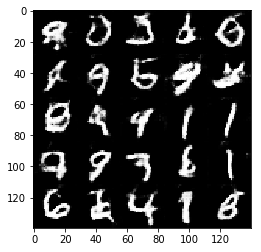

Epoch 2/2... Discriminator Loss: 1.0294... Generator Loss: 0.7956
Epoch 2/2... Discriminator Loss: 1.1824... Generator Loss: 0.6052
Epoch 2/2... Discriminator Loss: 1.0744... Generator Loss: 0.7275
Epoch 2/2... Discriminator Loss: 1.3334... Generator Loss: 0.4444
Epoch 2/2... Discriminator Loss: 1.4746... Generator Loss: 0.4007
Epoch 2/2... Discriminator Loss: 1.5435... Generator Loss: 0.3384
Epoch 2/2... Discriminator Loss: 1.1896... Generator Loss: 0.7437
Epoch 2/2... Discriminator Loss: 1.0086... Generator Loss: 1.3932
Epoch 2/2... Discriminator Loss: 1.1444... Generator Loss: 0.8721
Epoch 2/2... Discriminator Loss: 0.9585... Generator Loss: 1.2297


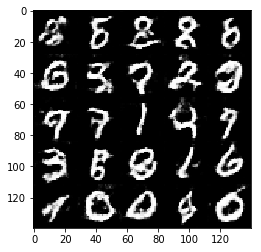

Epoch 2/2... Discriminator Loss: 0.9447... Generator Loss: 0.9611
Epoch 2/2... Discriminator Loss: 1.1738... Generator Loss: 0.6502
Epoch 2/2... Discriminator Loss: 1.0642... Generator Loss: 0.6997


In [17]:
batch_size = 128
z_dim = 256
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 0.4667... Generator Loss: 2.1165
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 0.6596... Generator Loss: 1.1533
Epoch 1/1... Discriminator Loss: 3.5036... Generator Loss: 0.0393
Epoch 1/1... Discriminator Loss: 0.1705... Generator Loss: 3.0480
Epoch 1/1... Discriminator Loss: 0.1809... Generator Loss: 2.2935
Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 1.6659


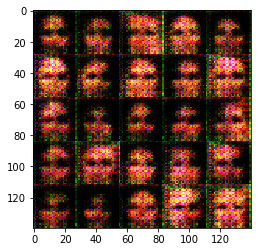

Epoch 1/1... Discriminator Loss: 0.0906... Generator Loss: 3.5085
Epoch 1/1... Discriminator Loss: 2.1581... Generator Loss: 3.4999
Epoch 1/1... Discriminator Loss: 0.2601... Generator Loss: 2.0360
Epoch 1/1... Discriminator Loss: 0.7166... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 2.8307... Generator Loss: 0.0769
Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 3.3415
Epoch 1/1... Discriminator Loss: 0.3767... Generator Loss: 1.3739
Epoch 1/1... Discriminator Loss: 0.3545... Generator Loss: 1.5774
Epoch 1/1... Discriminator Loss: 0.8107... Generator Loss: 0.9136


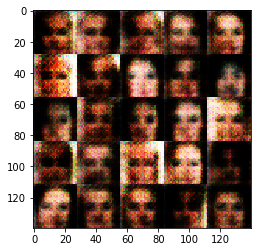

Epoch 1/1... Discriminator Loss: 0.2280... Generator Loss: 2.5944
Epoch 1/1... Discriminator Loss: 1.6535... Generator Loss: 0.2659
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 3.3832
Epoch 1/1... Discriminator Loss: 0.3083... Generator Loss: 2.3952
Epoch 1/1... Discriminator Loss: 0.7262... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 0.1327... Generator Loss: 2.9473
Epoch 1/1... Discriminator Loss: 1.7757... Generator Loss: 0.2737


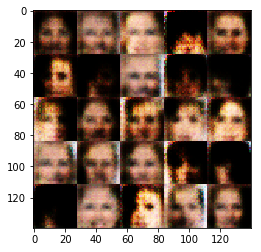

Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.3166
Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 1.2062
Epoch 1/1... Discriminator Loss: 0.4968... Generator Loss: 1.2763
Epoch 1/1... Discriminator Loss: 2.2125... Generator Loss: 0.1558
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.4362
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 0.5486... Generator Loss: 1.2773
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.5424


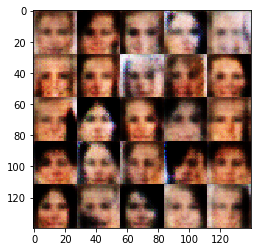

Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 2.2810
Epoch 1/1... Discriminator Loss: 0.8193... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.3441
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 1.4874
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 2.1316
Epoch 1/1... Discriminator Loss: 0.5864... Generator Loss: 1.9674
Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 0.5929... Generator Loss: 3.8291
Epoch 1/1... Discriminator Loss: 0.6281... Generator Loss: 1.0223


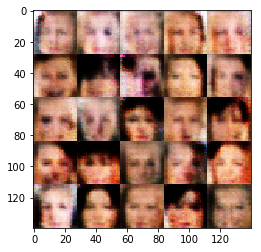

Epoch 1/1... Discriminator Loss: 0.4233... Generator Loss: 1.5480
Epoch 1/1... Discriminator Loss: 4.0233... Generator Loss: 5.9883
Epoch 1/1... Discriminator Loss: 0.5888... Generator Loss: 1.6497
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 0.4790... Generator Loss: 2.8801
Epoch 1/1... Discriminator Loss: 1.6085... Generator Loss: 0.2744
Epoch 1/1... Discriminator Loss: 0.8698... Generator Loss: 2.2740
Epoch 1/1... Discriminator Loss: 0.4615... Generator Loss: 1.7141
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 0.3360... Generator Loss: 3.1906


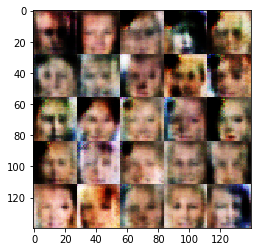

Epoch 1/1... Discriminator Loss: 2.0418... Generator Loss: 0.1828
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 4.2181
Epoch 1/1... Discriminator Loss: 0.8729... Generator Loss: 3.5183
Epoch 1/1... Discriminator Loss: 0.3568... Generator Loss: 2.3925
Epoch 1/1... Discriminator Loss: 0.2310... Generator Loss: 3.9858
Epoch 1/1... Discriminator Loss: 0.2245... Generator Loss: 6.3059
Epoch 1/1... Discriminator Loss: 5.5208... Generator Loss: 5.1823
Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 1.1729
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 0.7250


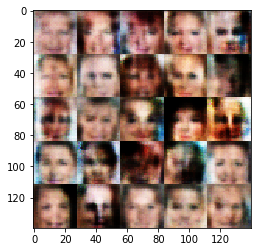

Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 2.3594
Epoch 1/1... Discriminator Loss: 0.4781... Generator Loss: 4.1015
Epoch 1/1... Discriminator Loss: 0.4955... Generator Loss: 1.3569
Epoch 1/1... Discriminator Loss: 0.2872... Generator Loss: 2.8867
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 0.7091... Generator Loss: 2.1971
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 0.2124... Generator Loss: 2.6286
Epoch 1/1... Discriminator Loss: 0.4560... Generator Loss: 1.5289
Epoch 1/1... Discriminator Loss: 0.6318... Generator Loss: 1.5292


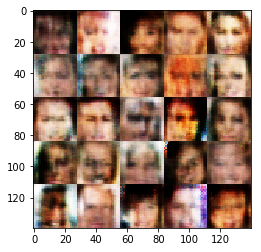

Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 2.3519
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 0.3270... Generator Loss: 1.9918
Epoch 1/1... Discriminator Loss: 0.8985... Generator Loss: 1.4358
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 3.5789
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 0.5112
Epoch 1/1... Discriminator Loss: 0.6462... Generator Loss: 1.6143
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.4298


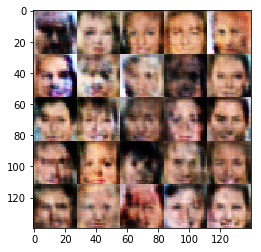

Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 4.5345
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 0.4107... Generator Loss: 2.5692
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 0.2451... Generator Loss: 2.1638
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 2.3403
Epoch 1/1... Discriminator Loss: 0.8193... Generator Loss: 1.7005
Epoch 1/1... Discriminator Loss: 0.6610... Generator Loss: 1.4193


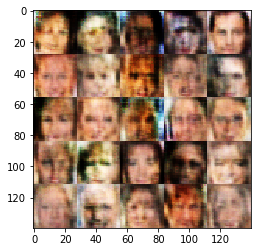

Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 1.8564
Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 1.1197
Epoch 1/1... Discriminator Loss: 0.7787... Generator Loss: 1.2275
Epoch 1/1... Discriminator Loss: 0.5998... Generator Loss: 1.2282
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.6652... Generator Loss: 0.2799
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.9433
Epoch 1/1... Discriminator Loss: 1.8207... Generator Loss: 0.2351


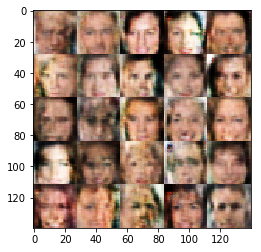

Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.1662
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.3742
Epoch 1/1... Discriminator Loss: 0.5029... Generator Loss: 1.6115
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 1.8238
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.4115


In [ ]:
batch_size = 128
z_dim = 256
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.